# Project 1 in course 02463

## Implementing Bayesian optimization for a CNN as a means to find optimal hyperparameters

### The code for the CNN was heavily inspired by the following kaggle article:
#### https://www.kaggle.com/mirhyun0508/2022-smarcle-ai-fashion-mnist-cnn



### Import dependencies

In [1]:
import sys
import os

from tensorflow import keras
from keras.datasets import mnist
from keras.utils import np_utils
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential

import GPyOpt

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from timeit import default_timer as timer

In [2]:
train = pd.read_csv('Data/fashion-mnist_train.csv')
test = pd.read_csv('Data/fashion-mnist_test.csv')

class_names = train.columns

In [3]:
train.head()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 359.3 MB


In [12]:
n_classes = 10
train_size = 600
test_size = 100

X_train = train.drop(["label"], axis=1)
y_train = train["label"]

X_test = test.drop(["label"], axis=1)
y_test = test["label"]

X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

where_train = []
where_test = []

for label in range(n_classes):
    where_train.append(np.where(y_train == label)[0][:round(train_size/10)])
    where_test.append(np.where(y_test == label)[0][:round(test_size/10)])

where_train = np.array(where_train).flatten()
where_test = np.array(where_test).flatten()

X_train = X_train[where_train]
y_train = y_train[where_train]

X_test = X_test[where_test]
y_test = y_test[where_test]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32') / 255
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32') / 255

(6000, 784)
(6000,)
(1000, 784)
(1000,)


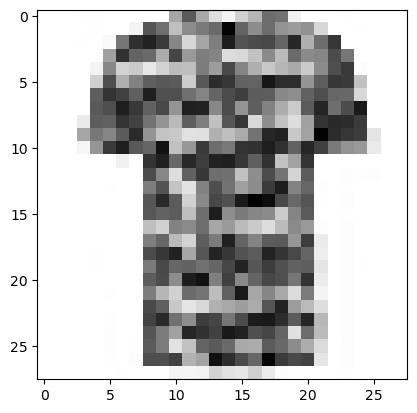

In [6]:
# Display an image
plt.imshow(X_train[0], cmap='Greys')
plt.show()

In [13]:
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

### Defining CNN class

In [14]:
class CNN:
    def __init__(self, X_train, y_train, X_test, y_test):
        #self.n_epochs = n_epochs
        #self.kernel_size = kernel_size
        #self.learning_rate = learning_rate
        #self.batch_size = batch_size
        
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        
        
        
    def CNNModelTrain(self, n_epochs, batch_size, kernel_size, learning_rate, summary = False):
        
        # The model is created
        model = Sequential()
        model.add(Conv2D(32, kernel_size=(kernel_size, kernel_size) , input_shape = (28, 28, 1), activation='relu'))
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(10, activation='softmax'))

        model.compile(loss='categorical_crossentropy', optimizer = keras.optimizers.Adam(learning_rate = learning_rate), metrics=['accuracy'])
        
        # Display model summary if true
        if summary == True:
            model.summary()
        
        # Train the model
        #MODEL_DIR = './model/'
        #if not os.path.exists(MODEL_DIR):
        #  os.mkdir(MODEL_DIR)

        #modelpath='./model/{epoch:02d}-{val_loss:.4f}.hdf5'
        #checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
        #early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)
        
        history = model.fit(X_train, y_train, 
        validation_data=(X_test, y_test), epochs=n_epochs, 
        batch_size= batch_size, verbose=1)
        #callbacks=[early_stopping_callback, checkpointer])
        
        accuracies = history.history['val_accuracy']
        return history, accuracies[-1]
    
    
    def plotResults(self, history):
        y_vacc = history.history['val_accuracy']

        y_acc = history.history['accuracy']


        x_len = np.arange(1,len(y_acc)+1, 1)
        plt.plot(x_len, y_vacc, marker='.', c='red', label='Testset_accuracy')
        plt.plot(x_len, y_acc, marker='.', c='blue', label='Trainset_accuracy')


        plt.legend(loc='upper right')
        plt.grid()
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.show()
    
        
        

### Create a model and train with fixed hyperparameters (deliberately bad)
#### The train-test dynamics are illustrated
##### Train and test accuracy is also visualized below

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 32)        832       
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 11, 11, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 11, 11, 64)        0         
                                                                 
 flatten (Flatten)           (None, 7744)              0         
                                                                 
 dense (Dense)               (None, 128)               991360    
                                                        

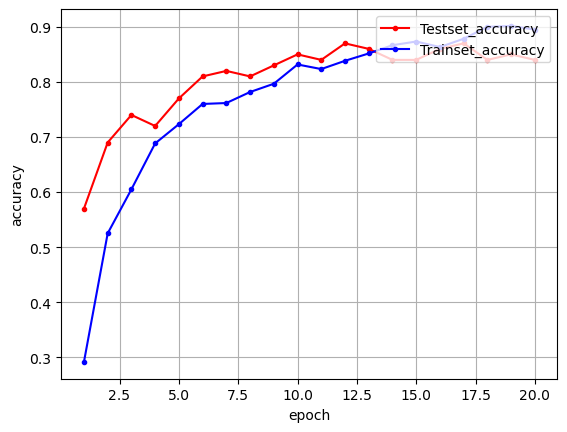

Accuracy at the last epoch: 0.8399999737739563
Loss at the last epoch: 0.44505128264427185


In [9]:
# If you want the model to perform well set lr = 0.001 and k = 3.

# Keep these values fixed if you want a decent but improvable result:
## e = 5, lr = 0.05, k = 5, b = 400
e = 20
lr = 0.001
k = 5
b = 100


m = CNN(X_train = X_train, y_train = y_train, X_test = X_test,y_test = y_test)
# Create a CNN model
hist, final_acc = m.CNNModelTrain(n_epochs = e, batch_size = b, kernel_size = k, learning_rate = lr,summary = True)


m.plotResults(hist)


final_loss = hist.history['val_loss'][-1]
print("Accuracy at the last epoch:", final_acc)
print("Loss at the last epoch:", final_loss)

## Implementing Exhaustive Search for finding the optimal hyperparameters

### Hyperparameters are defined:

In [24]:
# set fixed values for epochs and batch size
batch_size = 10
n_epochs = 20

# Kernel sizes
kernel_sizes = tuple(np.arange(1,8,2, dtype = np.int64))
# Learning rate:
lr = tuple(np.arange(0.001, 0.011, 0.001, dtype = np.float64))

print(kernel_sizes)
print(lr)

for l in lr:
    print(l)

(1, 3, 5, 7)
(0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009000000000000001, 0.010000000000000002)
0.001
0.002
0.003
0.004
0.005
0.006
0.007
0.008
0.009000000000000001
0.010000000000000002


In [25]:
# Record the time taken until convergence
start = timer()

final_losses = list()
final_accs = list()

optimal_hyperparams = [0,0]
best_acc = 0

for k in kernel_sizes:
    for l in lr:
        print(k,l)
        m = CNN(X_train = X_train, y_train = y_train, X_test = X_test,y_test = y_test)

        # Create CNN model and train it
        hist, acc = m.CNNModelTrain(n_epochs = n_epochs, batch_size = batch_size, 
                                kernel_size = k, learning_rate = l, summary = False)

        final_losses.append(hist.history['val_loss'][-1])
        final_accs.append(acc)

        if max(final_accs) > best_acc:
            best_acc = max(final_accs)
            optimal_hyperparams = [k, l]

end = timer()
print("The best accuracy was:", max(final_accs))
print("-------------------------------------------")
print("The best hyperparameters were found to be:")
print("Kernel size:", optimal_hyperparams[0])
print("Learning rate:", optimal_hyperparams[1])

print("It took", end-start, "time until convergence")


1 0.001
Epoch 1/20
60/60 [==============================] - 2s 19ms/step - loss: 1.5955 - accuracy: 0.4117 - val_loss: 0.8334 - val_accuracy: 0.7400
Epoch 2/20
60/60 [==============================] - 1s 16ms/step - loss: 0.9099 - accuracy: 0.7183 - val_loss: 0.6278 - val_accuracy: 0.7400
Epoch 3/20
60/60 [==============================] - 1s 16ms/step - loss: 0.7718 - accuracy: 0.7400 - val_loss: 0.5135 - val_accuracy: 0.8100
Epoch 4/20
60/60 [==============================] - 1s 16ms/step - loss: 0.5919 - accuracy: 0.7867 - val_loss: 0.5725 - val_accuracy: 0.7800
Epoch 5/20
60/60 [==============================] - 1s 16ms/step - loss: 0.5092 - accuracy: 0.8100 - val_loss: 0.5320 - val_accuracy: 0.8200
Epoch 6/20
60/60 [==============================] - 1s 15ms/step - loss: 0.4446 - accuracy: 0.8317 - val_loss: 0.5051 - val_accuracy: 0.8300
Epoch 7/20
60/60 [==============================] - 1s 16ms/step - loss: 0.3437 - accuracy: 0.8683 - val_loss: 0.6303 - val_accuracy: 0.8200
Epoch

Epoch 16/20
60/60 [==============================] - 1s 20ms/step - loss: 0.1919 - accuracy: 0.9350 - val_loss: 0.6520 - val_accuracy: 0.8500
Epoch 17/20
60/60 [==============================] - 1s 20ms/step - loss: 0.2301 - accuracy: 0.9217 - val_loss: 0.8072 - val_accuracy: 0.8200
Epoch 18/20
60/60 [==============================] - 1s 21ms/step - loss: 0.2313 - accuracy: 0.9150 - val_loss: 0.7456 - val_accuracy: 0.8400
Epoch 19/20
60/60 [==============================] - 1s 21ms/step - loss: 0.2102 - accuracy: 0.9167 - val_loss: 0.9012 - val_accuracy: 0.8300
Epoch 20/20
60/60 [==============================] - 1s 21ms/step - loss: 0.2034 - accuracy: 0.9183 - val_loss: 0.8899 - val_accuracy: 0.7900
1 0.007
Epoch 1/20
60/60 [==============================] - 2s 24ms/step - loss: 1.5852 - accuracy: 0.4533 - val_loss: 0.8513 - val_accuracy: 0.6900
Epoch 2/20
60/60 [==============================] - 1s 22ms/step - loss: 0.8179 - accuracy: 0.7117 - val_loss: 0.8321 - val_accuracy: 0.7600


Epoch 11/20
60/60 [==============================] - 1s 22ms/step - loss: 0.2428 - accuracy: 0.9133 - val_loss: 0.5890 - val_accuracy: 0.8000
Epoch 12/20
60/60 [==============================] - 1s 21ms/step - loss: 0.1774 - accuracy: 0.9317 - val_loss: 0.5777 - val_accuracy: 0.8000
Epoch 13/20
60/60 [==============================] - 1s 20ms/step - loss: 0.1957 - accuracy: 0.9317 - val_loss: 0.6037 - val_accuracy: 0.8500
Epoch 14/20
60/60 [==============================] - 1s 20ms/step - loss: 0.1347 - accuracy: 0.9483 - val_loss: 0.7251 - val_accuracy: 0.8300
Epoch 15/20
60/60 [==============================] - 1s 22ms/step - loss: 0.1406 - accuracy: 0.9583 - val_loss: 0.6879 - val_accuracy: 0.8400
Epoch 16/20
60/60 [==============================] - 1s 22ms/step - loss: 0.1582 - accuracy: 0.9383 - val_loss: 0.9696 - val_accuracy: 0.7700
Epoch 17/20
60/60 [==============================] - 1s 21ms/step - loss: 0.1529 - accuracy: 0.9417 - val_loss: 0.7167 - val_accuracy: 0.8400
Epoch 

Epoch 9/20
60/60 [==============================] - 1s 21ms/step - loss: 0.3725 - accuracy: 0.8583 - val_loss: 0.4118 - val_accuracy: 0.8300
Epoch 10/20
60/60 [==============================] - 1s 22ms/step - loss: 0.2908 - accuracy: 0.9033 - val_loss: 0.6112 - val_accuracy: 0.7800
Epoch 11/20
60/60 [==============================] - 1s 21ms/step - loss: 0.2383 - accuracy: 0.9100 - val_loss: 0.4970 - val_accuracy: 0.8200
Epoch 12/20
60/60 [==============================] - 1s 20ms/step - loss: 0.2419 - accuracy: 0.8967 - val_loss: 0.7425 - val_accuracy: 0.8100
Epoch 13/20
60/60 [==============================] - 1s 21ms/step - loss: 0.3010 - accuracy: 0.8933 - val_loss: 0.5056 - val_accuracy: 0.8000
Epoch 14/20
60/60 [==============================] - 1s 20ms/step - loss: 0.2322 - accuracy: 0.9183 - val_loss: 0.5345 - val_accuracy: 0.8200
Epoch 15/20
60/60 [==============================] - 1s 20ms/step - loss: 0.1785 - accuracy: 0.9433 - val_loss: 0.4770 - val_accuracy: 0.8300
Epoch 1

Epoch 7/20
60/60 [==============================] - 1s 20ms/step - loss: 0.5975 - accuracy: 0.7933 - val_loss: 0.6030 - val_accuracy: 0.7200
Epoch 8/20
60/60 [==============================] - 1s 20ms/step - loss: 0.5902 - accuracy: 0.7867 - val_loss: 0.5344 - val_accuracy: 0.7800
Epoch 9/20
60/60 [==============================] - 1s 21ms/step - loss: 0.5650 - accuracy: 0.7750 - val_loss: 0.5231 - val_accuracy: 0.8400
Epoch 10/20
60/60 [==============================] - 1s 20ms/step - loss: 0.4995 - accuracy: 0.8083 - val_loss: 0.5182 - val_accuracy: 0.8100
Epoch 11/20
60/60 [==============================] - 1s 20ms/step - loss: 0.4411 - accuracy: 0.8367 - val_loss: 0.4829 - val_accuracy: 0.8100
Epoch 12/20
60/60 [==============================] - 1s 21ms/step - loss: 0.3995 - accuracy: 0.8500 - val_loss: 0.4992 - val_accuracy: 0.8100
Epoch 13/20
60/60 [==============================] - 1s 20ms/step - loss: 0.4304 - accuracy: 0.8383 - val_loss: 0.6281 - val_accuracy: 0.7600
Epoch 14/

Epoch 2/20
60/60 [==============================] - 1s 19ms/step - loss: 0.9062 - accuracy: 0.6767 - val_loss: 0.6898 - val_accuracy: 0.7600
Epoch 3/20
60/60 [==============================] - 1s 21ms/step - loss: 0.7510 - accuracy: 0.7300 - val_loss: 0.5453 - val_accuracy: 0.7700
Epoch 4/20
60/60 [==============================] - 1s 19ms/step - loss: 0.6483 - accuracy: 0.7567 - val_loss: 0.6430 - val_accuracy: 0.7900
Epoch 5/20
60/60 [==============================] - 1s 19ms/step - loss: 0.5882 - accuracy: 0.7950 - val_loss: 0.7094 - val_accuracy: 0.7600
Epoch 6/20
60/60 [==============================] - 1s 18ms/step - loss: 0.5083 - accuracy: 0.8050 - val_loss: 0.6329 - val_accuracy: 0.8000
Epoch 7/20
60/60 [==============================] - 1s 18ms/step - loss: 0.4916 - accuracy: 0.8200 - val_loss: 0.5415 - val_accuracy: 0.7700
Epoch 8/20
60/60 [==============================] - 1s 17ms/step - loss: 0.4095 - accuracy: 0.8533 - val_loss: 0.5241 - val_accuracy: 0.7800
Epoch 9/20
60

Epoch 20/20
60/60 [==============================] - 1s 20ms/step - loss: 0.2496 - accuracy: 0.9167 - val_loss: 0.9296 - val_accuracy: 0.7800
5 0.007
Epoch 1/20
60/60 [==============================] - 2s 24ms/step - loss: 1.5106 - accuracy: 0.4983 - val_loss: 0.9443 - val_accuracy: 0.6400
Epoch 2/20
60/60 [==============================] - 1s 19ms/step - loss: 0.9517 - accuracy: 0.6550 - val_loss: 0.6533 - val_accuracy: 0.7800
Epoch 3/20
60/60 [==============================] - 1s 20ms/step - loss: 0.7575 - accuracy: 0.7333 - val_loss: 0.6656 - val_accuracy: 0.7500
Epoch 4/20
60/60 [==============================] - 1s 20ms/step - loss: 0.7435 - accuracy: 0.7367 - val_loss: 0.6673 - val_accuracy: 0.7300
Epoch 5/20
60/60 [==============================] - 1s 18ms/step - loss: 0.6475 - accuracy: 0.7800 - val_loss: 0.7789 - val_accuracy: 0.7500
Epoch 6/20
60/60 [==============================] - 1s 18ms/step - loss: 0.6653 - accuracy: 0.7700 - val_loss: 0.7295 - val_accuracy: 0.7500
Epoc

Epoch 15/20
60/60 [==============================] - 1s 15ms/step - loss: 0.2979 - accuracy: 0.8967 - val_loss: 0.5239 - val_accuracy: 0.8000
Epoch 16/20
60/60 [==============================] - 1s 15ms/step - loss: 0.2872 - accuracy: 0.8983 - val_loss: 0.5137 - val_accuracy: 0.8200
Epoch 17/20
60/60 [==============================] - 1s 16ms/step - loss: 0.3180 - accuracy: 0.8783 - val_loss: 0.5336 - val_accuracy: 0.7800
Epoch 18/20
60/60 [==============================] - 1s 18ms/step - loss: 0.2598 - accuracy: 0.8950 - val_loss: 0.5236 - val_accuracy: 0.8000
Epoch 19/20
60/60 [==============================] - 1s 18ms/step - loss: 0.2548 - accuracy: 0.9167 - val_loss: 0.7899 - val_accuracy: 0.7800
Epoch 20/20
60/60 [==============================] - 1s 18ms/step - loss: 0.1958 - accuracy: 0.9267 - val_loss: 0.5760 - val_accuracy: 0.8300
7 0.003
Epoch 1/20
60/60 [==============================] - 2s 19ms/step - loss: 1.6430 - accuracy: 0.4100 - val_loss: 1.0356 - val_accuracy: 0.5700

Epoch 13/20
60/60 [==============================] - 1s 17ms/step - loss: 0.4345 - accuracy: 0.8133 - val_loss: 0.6939 - val_accuracy: 0.8200
Epoch 14/20
60/60 [==============================] - 1s 16ms/step - loss: 0.4121 - accuracy: 0.8450 - val_loss: 0.7737 - val_accuracy: 0.7400
Epoch 15/20
60/60 [==============================] - 1s 16ms/step - loss: 0.4106 - accuracy: 0.8633 - val_loss: 0.6613 - val_accuracy: 0.7600
Epoch 16/20
60/60 [==============================] - 1s 15ms/step - loss: 0.4344 - accuracy: 0.8250 - val_loss: 0.6208 - val_accuracy: 0.7800
Epoch 17/20
60/60 [==============================] - 1s 15ms/step - loss: 0.3787 - accuracy: 0.8550 - val_loss: 0.7433 - val_accuracy: 0.8300
Epoch 18/20
60/60 [==============================] - 1s 15ms/step - loss: 0.3530 - accuracy: 0.8783 - val_loss: 0.5484 - val_accuracy: 0.8200
Epoch 19/20
60/60 [==============================] - 1s 15ms/step - loss: 0.3416 - accuracy: 0.8767 - val_loss: 0.8006 - val_accuracy: 0.7700
Epoch 

Epoch 11/20
60/60 [==============================] - 1s 19ms/step - loss: 0.5999 - accuracy: 0.7667 - val_loss: 0.6784 - val_accuracy: 0.7700
Epoch 12/20
60/60 [==============================] - 1s 20ms/step - loss: 0.5531 - accuracy: 0.7850 - val_loss: 0.8132 - val_accuracy: 0.7100
Epoch 13/20
60/60 [==============================] - 1s 21ms/step - loss: 0.5562 - accuracy: 0.7783 - val_loss: 0.6465 - val_accuracy: 0.7900
Epoch 14/20
60/60 [==============================] - 1s 20ms/step - loss: 0.5363 - accuracy: 0.7867 - val_loss: 0.6550 - val_accuracy: 0.7900
Epoch 15/20
60/60 [==============================] - 1s 19ms/step - loss: 0.4834 - accuracy: 0.8183 - val_loss: 0.6828 - val_accuracy: 0.7500
Epoch 16/20
60/60 [==============================] - 1s 16ms/step - loss: 0.4671 - accuracy: 0.8217 - val_loss: 0.6658 - val_accuracy: 0.7800
Epoch 17/20
60/60 [==============================] - 1s 15ms/step - loss: 0.4923 - accuracy: 0.8133 - val_loss: 0.5946 - val_accuracy: 0.7500
Epoch 

In [15]:
def CNN_Model_Train( kernel_size, learning_rate, n_epochs = 5,batch_size = 300):
    
    # The model is created
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(int(kernel_size), int(kernel_size)) , input_shape = (28, 28, 1), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer = keras.optimizers.Adam(learning_rate = learning_rate), metrics=['accuracy'])
    
    
    # Train the model
    MODEL_DIR = './model/'
    if not os.path.exists(MODEL_DIR):
        os.mkdir(MODEL_DIR)

    modelpath='./model/{epoch:02d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
    early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)

    history = model.fit(X_train, y_train, 
    validation_data=(X_test, y_test), epochs=n_epochs, 
    batch_size= batch_size, verbose=1, 
    callbacks=[early_stopping_callback, checkpointer])

    accuracies = history.history['val_accuracy']
    return accuracies[-1]

## Bayesian optimization using GpyOpt

#### This code is inspired by code from Exercise 4 in course 02463

Acquistion used is: EI
Epoch 1/5
20/20 [==============================] - ETA: 0s - loss: 1.7985 - accuracy: 0.4540
Epoch 00001: val_loss improved from inf to 0.76691, saving model to ./model\01-0.7669.hdf5
20/20 [==============================] - 4s 155ms/step - loss: 1.7985 - accuracy: 0.4540 - val_loss: 0.7669 - val_accuracy: 0.7200
Epoch 2/5
20/20 [==============================] - ETA: 0s - loss: 0.7475 - accuracy: 0.7217
Epoch 00002: val_loss improved from 0.76691 to 0.55089, saving model to ./model\02-0.5509.hdf5
20/20 [==============================] - 3s 152ms/step - loss: 0.7475 - accuracy: 0.7217 - val_loss: 0.5509 - val_accuracy: 0.7960
Epoch 3/5
20/20 [==============================] - ETA: 0s - loss: 0.5911 - accuracy: 0.7797
Epoch 00003: val_loss improved from 0.55089 to 0.49765, saving model to ./model\03-0.4976.hdf5
20/20 [==============================] - 3s 151ms/step - loss: 0.5911 - accuracy: 0.7797 - val_loss: 0.4976 - val_accuracy: 0.8050
Epoch 4/5
20/20 [=======

Epoch 2/5
20/20 [==============================] - ETA: 0s - loss: 0.6239 - accuracy: 0.7677
Epoch 00002: val_loss improved from 0.56843 to 0.48136, saving model to ./model\02-0.4814.hdf5
20/20 [==============================] - 5s 260ms/step - loss: 0.6239 - accuracy: 0.7677 - val_loss: 0.4814 - val_accuracy: 0.8200
Epoch 3/5
20/20 [==============================] - ETA: 0s - loss: 0.5008 - accuracy: 0.8147
Epoch 00003: val_loss improved from 0.48136 to 0.42172, saving model to ./model\03-0.4217.hdf5
20/20 [==============================] - 5s 256ms/step - loss: 0.5008 - accuracy: 0.8147 - val_loss: 0.4217 - val_accuracy: 0.8460
Epoch 4/5
20/20 [==============================] - ETA: 0s - loss: 0.4476 - accuracy: 0.8395
Epoch 00004: val_loss improved from 0.42172 to 0.36991, saving model to ./model\04-0.3699.hdf5
20/20 [==============================] - 5s 261ms/step - loss: 0.4476 - accuracy: 0.8395 - val_loss: 0.3699 - val_accuracy: 0.8700
Epoch 5/5
20/20 [==========================

Epoch 3/5
20/20 [==============================] - ETA: 0s - loss: 0.5519 - accuracy: 0.7950
Epoch 00003: val_loss improved from 0.51578 to 0.46452, saving model to ./model\03-0.4645.hdf5
20/20 [==============================] - 5s 228ms/step - loss: 0.5519 - accuracy: 0.7950 - val_loss: 0.4645 - val_accuracy: 0.8200
Epoch 4/5
20/20 [==============================] - ETA: 0s - loss: 0.4905 - accuracy: 0.8180
Epoch 00004: val_loss improved from 0.46452 to 0.42721, saving model to ./model\04-0.4272.hdf5
20/20 [==============================] - 5s 251ms/step - loss: 0.4905 - accuracy: 0.8180 - val_loss: 0.4272 - val_accuracy: 0.8380
Epoch 5/5
20/20 [==============================] - ETA: 0s - loss: 0.4568 - accuracy: 0.8288
Epoch 00005: val_loss improved from 0.42721 to 0.42686, saving model to ./model\05-0.4269.hdf5
20/20 [==============================] - 5s 243ms/step - loss: 0.4568 - accuracy: 0.8288 - val_loss: 0.4269 - val_accuracy: 0.8400
Epoch 1/5
20/20 [==========================

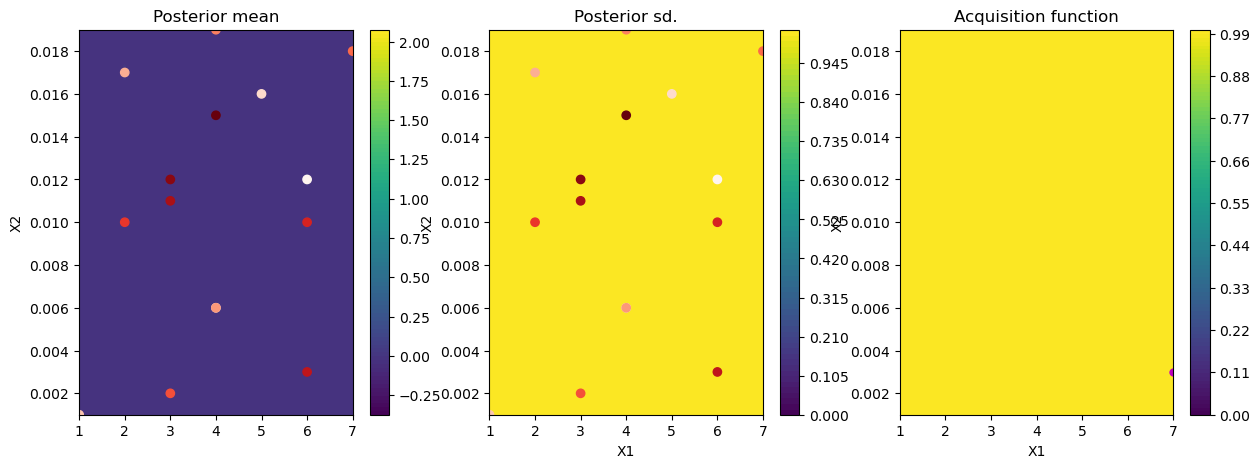

Acquistion used is: MPI
Epoch 1/5
20/20 [==============================] - ETA: 0s - loss: 1.2725 - accuracy: 0.5700
Epoch 00001: val_loss improved from inf to 0.57894, saving model to ./model\01-0.5789.hdf5
20/20 [==============================] - 7s 308ms/step - loss: 1.2725 - accuracy: 0.5700 - val_loss: 0.5789 - val_accuracy: 0.7820
Epoch 2/5
20/20 [==============================] - ETA: 0s - loss: 0.6013 - accuracy: 0.7803
Epoch 00002: val_loss improved from 0.57894 to 0.47497, saving model to ./model\02-0.4750.hdf5
20/20 [==============================] - 6s 288ms/step - loss: 0.6013 - accuracy: 0.7803 - val_loss: 0.4750 - val_accuracy: 0.8180
Epoch 3/5
20/20 [==============================] - ETA: 0s - loss: 0.4859 - accuracy: 0.8255
Epoch 00003: val_loss improved from 0.47497 to 0.41642, saving model to ./model\03-0.4164.hdf5
20/20 [==============================] - 6s 290ms/step - loss: 0.4859 - accuracy: 0.8255 - val_loss: 0.4164 - val_accuracy: 0.8390
Epoch 4/5
20/20 [======

Epoch 2/5
20/20 [==============================] - ETA: 0s - loss: 0.6517 - accuracy: 0.7693
Epoch 00002: val_loss improved from 0.62767 to 0.48890, saving model to ./model\02-0.4889.hdf5
20/20 [==============================] - 6s 313ms/step - loss: 0.6517 - accuracy: 0.7693 - val_loss: 0.4889 - val_accuracy: 0.8140
Epoch 3/5
20/20 [==============================] - ETA: 0s - loss: 0.5437 - accuracy: 0.8025
Epoch 00003: val_loss improved from 0.48890 to 0.41816, saving model to ./model\03-0.4182.hdf5
20/20 [==============================] - 6s 316ms/step - loss: 0.5437 - accuracy: 0.8025 - val_loss: 0.4182 - val_accuracy: 0.8410
Epoch 4/5
20/20 [==============================] - ETA: 0s - loss: 0.4473 - accuracy: 0.8408
Epoch 00004: val_loss improved from 0.41816 to 0.38977, saving model to ./model\04-0.3898.hdf5
20/20 [==============================] - 6s 313ms/step - loss: 0.4473 - accuracy: 0.8408 - val_loss: 0.3898 - val_accuracy: 0.8570
Epoch 5/5
20/20 [==========================

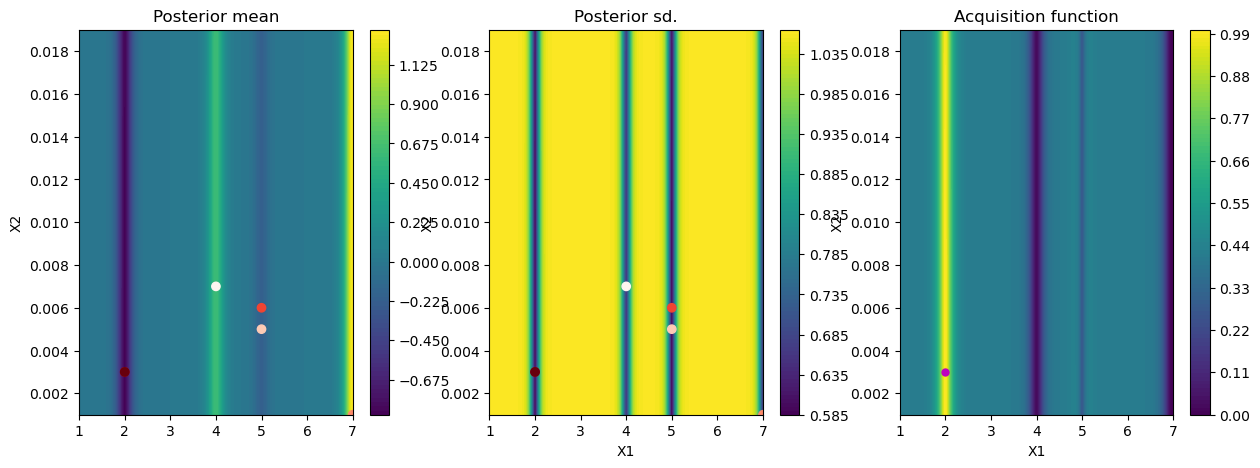

Acquistion used is: LCB
Epoch 1/5
20/20 [==============================] - ETA: 0s - loss: 1.4007 - accuracy: 0.5715
Epoch 00001: val_loss improved from inf to 0.56763, saving model to ./model\01-0.5676.hdf5
20/20 [==============================] - 7s 341ms/step - loss: 1.4007 - accuracy: 0.5715 - val_loss: 0.5676 - val_accuracy: 0.7940
Epoch 2/5
20/20 [==============================] - ETA: 0s - loss: 0.5766 - accuracy: 0.7917
Epoch 00002: val_loss improved from 0.56763 to 0.46457, saving model to ./model\02-0.4646.hdf5
20/20 [==============================] - 6s 320ms/step - loss: 0.5766 - accuracy: 0.7917 - val_loss: 0.4646 - val_accuracy: 0.8160
Epoch 3/5
20/20 [==============================] - ETA: 0s - loss: 0.4719 - accuracy: 0.8278
Epoch 00003: val_loss improved from 0.46457 to 0.37222, saving model to ./model\03-0.3722.hdf5
20/20 [==============================] - 7s 330ms/step - loss: 0.4719 - accuracy: 0.8278 - val_loss: 0.3722 - val_accuracy: 0.8710
Epoch 4/5
20/20 [======

Epoch 2/5
20/20 [==============================] - ETA: 0s - loss: 0.5427 - accuracy: 0.8098
Epoch 00002: val_loss improved from 0.51832 to 0.43600, saving model to ./model\02-0.4360.hdf5
20/20 [==============================] - 7s 347ms/step - loss: 0.5427 - accuracy: 0.8098 - val_loss: 0.4360 - val_accuracy: 0.8450
Epoch 3/5
20/20 [==============================] - ETA: 0s - loss: 0.4455 - accuracy: 0.8380
Epoch 00003: val_loss improved from 0.43600 to 0.36684, saving model to ./model\03-0.3668.hdf5
20/20 [==============================] - 7s 348ms/step - loss: 0.4455 - accuracy: 0.8380 - val_loss: 0.3668 - val_accuracy: 0.8720
Epoch 4/5
20/20 [==============================] - ETA: 0s - loss: 0.3717 - accuracy: 0.8655
Epoch 00004: val_loss improved from 0.36684 to 0.34916, saving model to ./model\04-0.3492.hdf5
20/20 [==============================] - 7s 342ms/step - loss: 0.3717 - accuracy: 0.8655 - val_loss: 0.3492 - val_accuracy: 0.8710
Epoch 5/5
20/20 [==========================

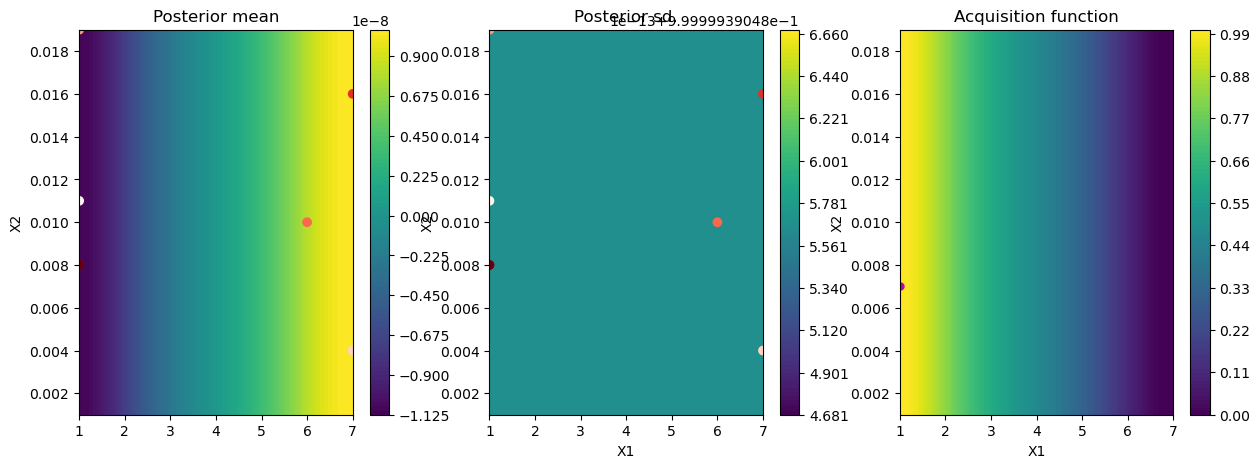

In [16]:
from numpy.random import seed
seed(1)
from tensorflow.random import set_seed
set_seed(2)
start = timer()

# set fixed values for epochs and batch size
batch_size = 10
n_epochs = 20

# Same hyperparameters as before:
## Kernel sizes
kernel_sizes = tuple(np.arange(1,8,1, dtype = np.int64))
## Learning rate:
lr = tuple(np.arange(0.001, 0.02, 0.001, dtype = np.float64))



domain = [{'name': 'kernel_sizes', 'type': 'discrete', 'domain': kernel_sizes},
          {'name': 'learning_rate', 'type': 'discrete', 'domain': lr},
          ]

def objective_function(x):
    param = x[0]
    
    acc = CNN_Model_Train(kernel_size = param[0], learning_rate = param[1])
    
    return -float(acc)

for acq in ["EI","MPI","LCB"]:
    print("Acquistion used is:",acq)
    ### EI acquisition function ###
    acquisition_func = acq

    opt = GPyOpt.methods.BayesianOptimization(f = objective_function,   # function to optimize
                                                  domain = domain,         # box-constrains of the problem
                                                  acquisition_type = acquisition_func      # Select acquisition function MPI, EI, LCB
                                                 )
    opt.acquisition.exploration_weight=.1

    opt.run_optimization(max_iter = 10) 

    x_best = opt.X[np.argmin(opt.Y)]

    end = timer()
    print("For acquisition_type: {0}".format(acquisition_func))
    print("time: {0}".format(end - start))
    print("The best parameters obtained: {0}".format(x_best))
    print("The accuracy was: {0}".format(-min(opt.Y)))
    
    opt.plot_acquisition()

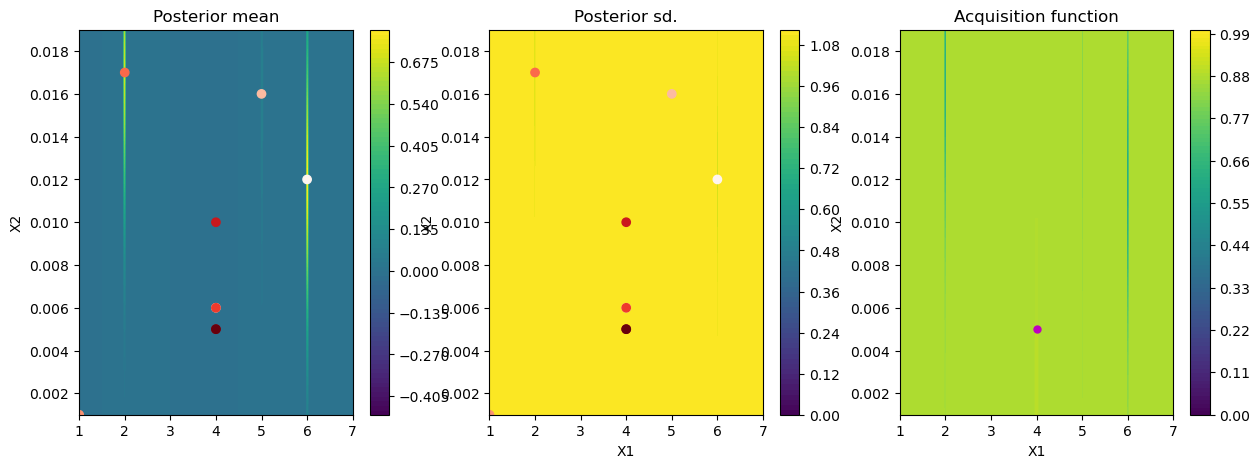

In [73]:
opt.plot_acquisition()

In [ ]:
### MPI acquisition function ###
acquisition_func = "MPI"

opt = GPyOpt.methods.BayesianOptimization(f = objective_function,   # function to optimize
                                              domain = domain,         # box-constrains of the problem
                                              acquisition_type = acquisition_func      # Select acquisition function MPI, EI, LCB
                                             )
opt.acquisition.exploration_weight=.1

opt.run_optimization(max_iter = 10) 

x_best = opt.X[np.argmin(opt.Y)]

end = timer()
print("For acquisition_type: {0}".format(acquisition_func))
print("time: {0}".format(end - start))
print("The best parameters obtained: {0}".format(x_best))
print("The loss was: {0}".format(min(opt.Y)))








### MPI acquisition function ###
acquisition_func = "LCB"

opt = GPyOpt.methods.BayesianOptimization(f = objective_function,   # function to optimize
                                              domain = domain,         # box-constrains of the problem
                                              acquisition_type = acquisition_func      # Select acquisition function MPI, EI, LCB
                                             )
opt.acquisition.exploration_weight=.1

opt.run_optimization(max_iter = 10) 

x_best = opt.X[np.argmin(opt.Y)]

end = timer()
print("For acquisition_type: {0}".format(acquisition_func))
print("time: {0}".format(end - start))
print("The best parameters obtained: {0}".format(x_best))
print("The loss was: {0}".format(min(opt.Y)))